In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint
from scipy.integrate import quad
import seaborn as sns
import matplotlib.colors as colors
from matplotlib import rcParams
from scipy.interpolate import InterpolatedUnivariateSpline
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})


π = np.pi
G = 4.4959e-15            #in units of M☉^-1 pc^3 yr^-2
c = 0.3068                #in units of pc yr^-1
ρ_eq = 3.1812e3           #in units of M☉ pc^-3 with ρ_eq=2.15368e-16 kg m^-3
t = 13.78e9               #in units of yrs corresponding to t_0=13.78Gyr
yr = 3.154e7              # in units of seconds
pc = 3.0857e16            # in meters
yr = 3.154e7              # in units of seconds
t_eq = 1.59246e12/yr      # in units of seconds
ρ_m  = 4e19                #ρ_m=4e19 M☉ Gpc^-3
t_m = 13.78e9             #in units of yr 
σ_eq = 0.005



def merger_IMRIPY(m_1, m_2, Δ_1, Δ_2, t_m, DM_halos_presence):
    
    if m_1 < 5 or m_2 < 5:
        return 0
    
    elif m_1 < m_2:
        return 0
    
    else: #1
        beta = 0.75
        gamma  =  0.65
        delta = -0.89
        a_i_ref =  file['arr_2']   # in units of pc
        m1_ref = 1      # in units of solar mass.
        m2_ref = 1e-3   # in units of solar mass.

        def f_(m):
            return f*P(m)

        def f_b(m_1,m_2):
            return  f_(m_1)+f_(m_2)

        def λ(m_1, m_2, Δ_1, Δ_2, X): # λ_0
            return  X/(f_b(m_1,m_2)*np.sqrt(Δ_1*Δ_2))

        def PDF(m):
            return (P(m)/m)


        I = quad(PDF, m_min, m_max)             # Taking limits of the PBH mass from m_min M☉ to m_max M☉ instead of 
                                             # 0 to infinity.

        n_T = f * ρ_eq * I[0]                #n_T=f*ρ_eq∫(P(m)/m)*dm 

        def x̄(m_1,m_2,Δ_1,Δ_2):
            return (((3 * (m_1 + m_2))/(8 * π * ρ_eq * f_b(m_1,m_2) * np.sqrt(Δ_1 * Δ_2)))**(1/3))
    
        X = np.geomspace(X_min, X_max, 1000) 
        
        
        if DM_halos_presence == 'False':
            
            def a_initial(m_1, m_2, Δ_1, Δ_2, X):  # for x = x_bar 
                return (0.0965*λ(m_1,m_2,Δ_1,Δ_2, X) + 0.0165*(λ(m_1,m_2,Δ_1,Δ_2, X)**2)) * x̄(m_1,m_2,Δ_1,Δ_2) * (X**(1/3))


            def C(m_1,m_2,Δ_1,Δ_2, X):
                return ((a_initial(m_1,m_2,Δ_1,Δ_2, X)/a_i_ref)**(beta)) * ((m_1/ m1_ref)**(gamma)) * ((m_2/m2_ref)**(delta))

            
            C_list = (C(m_1,m_2,Δ_1,Δ_2, X)).tolist()
            j_initial_list = np.zeros(len(C_list))
            j_initial_prime_list  = np.zeros(len(C_list))
            
            for i, C in enumerate(C_list):
                variable = t_m/C
                if variable < tm_ref_list[0]:
                    m = file['arr_0']
                    b = file['arr_1']
                    j_i = (10**(-b/m))   * (t_m**(1/m))   # t_m = (j_i**m) * (10**b)
                    j_i_prime = (1/m) * ((1/C)**(1/m)) * (10**(-b/m)) * (t_m**(-(m-1)/m))
                  
                elif tm_ref_list[0] < variable < tm_ref_list[-1]:
                    g =  InterpolatedUnivariateSpline(tm_ref_list, ji_ref_list, ext = 2, k= 2) # j_i = g(t_m)
                    g_prime = g.derivative()
                    j_i = g(variable)
                    j_i_prime = (1/C) * g_prime(variable) 
                
                else: 
                    variable =  tm_ref_list[-1]
                    g =  InterpolatedUnivariateSpline(tm_ref_list, ji_ref_list, ext = 2, k= 2) # j_i = g(t_m)
                    g_prime = g.derivative()
                    j_i = g(variable)
                    j_i_prime = (1/C) * g_prime(variable) 
                
                j_initial_list[i]       =  j_i
                j_initial_prime_list[i] =  j_i_prime
                
                       
                
            j_initial = np.array(j_initial_list) 
            j_initial_prime = np.array(j_initial_prime_list)
            
            # Merger rate of  PBH binaries without halos for PBHs mass range of m_min M☉ - m_max M☉.
            def D(m_1, m_2, Δ_1, Δ_2, X):
                return ( 1 + 0.0443 * λ(m_1, m_2, Δ_1, Δ_2, X))/ np.sqrt(1 + 0.1709 * λ(m_1, m_2, Δ_1, Δ_2, X))

            
            def j_X(m_1, m_2, Δ_1, Δ_2, X):
                return 0.4108 * np.sqrt(f**2 + 1.1994 * (σ_eq**2)) * D(m_1, m_2, Δ_1, Δ_2, X) * (X/(f_b(m_1,m_2) * np.sqrt(Δ_1*Δ_2)))

            
            def γ_X(m_1,m_2,Δ_1,Δ_2, X):    
                 return j_initial/ j_X(m_1, m_2, Δ_1, Δ_2, X)

            
            def integrand(m_1,m_2,Δ_1,Δ_2, X):
                return j_initial_prime * (1/j_initial) * ((γ_X(m_1,m_2,Δ_1,Δ_2, X)**2)/ ((1 + (γ_X(m_1,m_2,Δ_1,Δ_2, X)**2))**(3/2))) * np.exp(- X * ((4*π)/3) * (x̄(m_1,m_2,Δ_1,Δ_2)**3) * n_T)

            
            return  (ρ_m/2) * (((f**2)* (m_1 + m_2))/(f_b(m_1,m_2) * np.sqrt(Δ_1*Δ_2))) * np.minimum((P(m_1)*Δ_1)/m_1, (P(m_2)*Δ_2)/m_2) * ((P(m_1)*Δ_1)/m_1 + (P(m_2)*Δ_2)/m_2) *   (np.trapz(integrand(m_1,m_2,Δ_1,Δ_2, X),X))
        
        
        else: #3
            
            def a_initial(m_1, m_2, Δ_1, Δ_2, X):  # for x = x_bar 
                return (0.0977*λ(m_1,m_2,Δ_1,Δ_2, X) + 0.0057*(λ(m_1,m_2,Δ_1,Δ_2, X)**2)) * x̄(m_1,m_2,Δ_1,Δ_2) * (X**(1/3))


            def C(m_1,m_2,Δ_1,Δ_2, X):
                return ((a_initial(m_1,m_2,Δ_1,Δ_2, X)/a_i_ref)**(beta)) * ((m_1/ m1_ref)**(gamma)) * ((m_2/m2_ref)**(delta))

            C_list = (C(m_1,m_2,Δ_1,Δ_2, X)).tolist()
            j_initial_list = np.zeros(len(C_list))
            j_initial_prime_list  = np.zeros(len(C_list))
            
            
            for i, C in enumerate(C_list):
                variable = t_m/C
                
                if variable < tm_ref_list[0]:
                    m = file['arr_0']
                    b = file['arr_1']
                    j_i = (10**(-b/m))   * (t_m**(1/m))   # t_m = (j_i**m) * (10**b)
                    j_i_prime = (1/m) * ((1/C)**(1/m)) * (10**(-b/m)) * (t_m**(-(m-1)/m))
                  
                elif tm_ref_list[0] < variable < tm_ref_list[-1]:
                    g =  InterpolatedUnivariateSpline(tm_ref_list, ji_ref_list, ext = 2, k= 2) # j_i = g(t_m)
                    g_prime = g.derivative()
                    j_i = g(variable)
                    j_i_prime = (1/C) * g_prime(variable) 
                
                else: 
                    variable = 0
                    g =  InterpolatedUnivariateSpline(tm_ref_list, ji_ref_list, ext = 2, k= 2) # j_i = g(t_m)
                    g_prime = g.derivative()
                    j_i = 0
                    j_i_prime = 0
                
                j_initial_list[i]       =  j_i
                j_initial_prime_list[i] =  j_i_prime
                
            
            j_initial = np.array(j_initial_list) 
            j_initial_prime = np.array(j_initial_prime_list)
            
            
            def s(m_1, m_2, Δ_1, Δ_2, X): # S_dec of the binary decouple.
                return ((0.03095*λ(m_1, m_2, Δ_1, Δ_2, X)+ 0.3425)*λ(m_1, m_2, Δ_1, Δ_2, X))

            def t(m_1, m_2, Δ_1, Δ_2, X):  #t_dec of the binary decouple.
                return ((np.sqrt(3/(8*π*G*ρ_eq)))*(((2/3)*(s(m_1, m_2, Δ_1, Δ_2, X)-2)*np.sqrt(s(m_1, m_2, Δ_1, Δ_2, X)+1))+(4/3)))


            def ρ_bar(m):
                return ((ρ_eq/2)*(t_eq**(3/2))*((2*G*m)**(3/4))) 

            def M_halo(m, m_1, m_2, Δ_1, Δ_2, X):
                return (((16*π)/3)*ρ_bar(m)*((2 * G * m *(t(m_1, m_2, Δ_1, Δ_2, X)**2))**(1/4)))
 
            def M(m, m_1, m_2, Δ_1, Δ_2, X):
                return (m + M_halo(m, m_1, m_2, Δ_1, Δ_2, X))
   
            def M_binary_initial(m_1, m_2, Δ_1, Δ_2, X):
                return (m_1 + m_2 + M_halo(m_1, m_1, m_2, Δ_1, Δ_2, X) + M_halo(m_2, m_1, m_2, Δ_1, Δ_2, X))

                # Merger rate of  PBH binaries without halos for PBHs mass range of m_min M☉ - m_max M☉.
            def D_halo(m_1, m_2, Δ_1, Δ_2, X):
                return ( 1 + 0.0857 * λ(m_1, m_2, Δ_1, Δ_2, X))/ np.sqrt(1 + 0.0583 * λ(m_1, m_2, Δ_1, Δ_2, X))

            
            def j_X_halo(m_1, m_2, Δ_1, Δ_2, X):
                return 0.4087 * np.sqrt(f**2 + 0.2998 * (σ_eq**2)) * D_halo(m_1, m_2, Δ_1, Δ_2, X) * np.sqrt((m_1 + m_2)/ M_binary_initial(m_1, m_2, Δ_1, Δ_2, X)) * (X/(f_b(m_1,m_2) * np.sqrt(Δ_1*Δ_2)))

            
            def γ_X_halo(m_1,m_2,Δ_1,Δ_2, X):    
                return j_initial/ j_X_halo(m_1, m_2, Δ_1, Δ_2, X)

            
            def integrand_halo(m_1,m_2,Δ_1,Δ_2, X):
                return j_initial_prime * (1/j_initial) * ((γ_X_halo(m_1,m_2,Δ_1,Δ_2, X)**2)/ ((1 + (γ_X_halo(m_1,m_2,Δ_1,Δ_2, X)**2))**(3/2))) * np.exp(- X * ((4*π)/3) * (x̄(m_1,m_2,Δ_1,Δ_2)**3) * n_T)

            return  (ρ_m/2) * (((f**2)* (m_1 + m_2))/(f_b(m_1,m_2) * np.sqrt(Δ_1*Δ_2))) * np.minimum((P(m_1)*Δ_1)/m_1, (P(m_2)*Δ_2)/m_2) * ((P(m_1)*Δ_1)/m_1 + (P(m_2)*Δ_2)/m_2) *   (np.trapz(integrand_halo(m_1,m_2,Δ_1,Δ_2, X),X))       



In [2]:
file = np.load('tm_ofj0_PWRhalo_1.npz')
m = file['arr_0']
b = file['arr_1']
a_i_ref =  file['arr_2']
ji_ref_list = file['arr_3']
tm_ref_list = file['arr_4']


# Calculation of the 2D merger rate for Power Law PBH mass Distribution. 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2.
m_1 = 7       #in units of M☉
m_2 = 9      #in units of M☉



y_1 = np.log(m_1)
y_2 = np.log(m_2)
dy = (y_2-y_1)


y_list = np.zeros(11)

for i in range(len(y_list)):
    y_list[i] = (y_1 + (i*dy))
    

M_1_list = np.zeros(len(y_list))
M_2_list = np.zeros(len(y_list))

for i, y in enumerate(y_list):
    M_1_list[i] = (np.ceil(np.exp(y)))
    M_2_list[i] = (np.ceil(np.exp(y)))
    

            
m_1_list = [int(M_1) for M_1 in M_1_list]
m_2_list = [int(M_2) for M_2 in M_2_list]

    
Δ_1_list = np.zeros(len(y_list))
Δ_2_list = np.zeros(len(y_list))

for i, y in enumerate(y_list):
    Δ_1_list[i] = np.exp(y + 0.5*dy) - np.exp(y - 0.5*dy)
    Δ_2_list[i] = np.exp(y + 0.5*dy) - np.exp(y - 0.5*dy) 

    
print("m_1 =", m_1_list, "M☉")
print('\v')
print("Δ_1 =", Δ_1_list)




m_min = 5     #in units of M☉
m_max = 100   # in units of M☉

X_min = 1e-15
X_max = 1e5

m_1 = [7, 10, 12, 15, 20, 25, 32, 41, 53, 68, 87] M☉

Δ_1 = [ 1.76383421  2.26778684  2.91572593  3.74879049  4.81987348  6.19698019
  7.96754596 10.24398767 13.17084129 16.9339388  21.77220702]


/tmp/ipykernel_5587/1207438708.py:211: RuntimeWarning: divide by zero encountered in true_divide
  return j_initial_prime * (1/j_initial) * ((γ_X_halo(m_1,m_2,Δ_1,Δ_2, X)**2)/ ((1 + (γ_X_halo(m_1,m_2,Δ_1,Δ_2, X)**2))**(3/2))) * np.exp(- X * ((4*π)/3) * (x̄(m_1,m_2,Δ_1,Δ_2)**3) * n_T)
/tmp/ipykernel_5587/1207438708.py:211: RuntimeWarning: invalid value encountered in multiply
  return j_initial_prime * (1/j_initial) * ((γ_X_halo(m_1,m_2,Δ_1,Δ_2, X)**2)/ ((1 + (γ_X_halo(m_1,m_2,Δ_1,Δ_2, X)**2))**(3/2))) * np.exp(- X * ((4*π)/3) * (x̄(m_1,m_2,Δ_1,Δ_2)**3) * n_T)


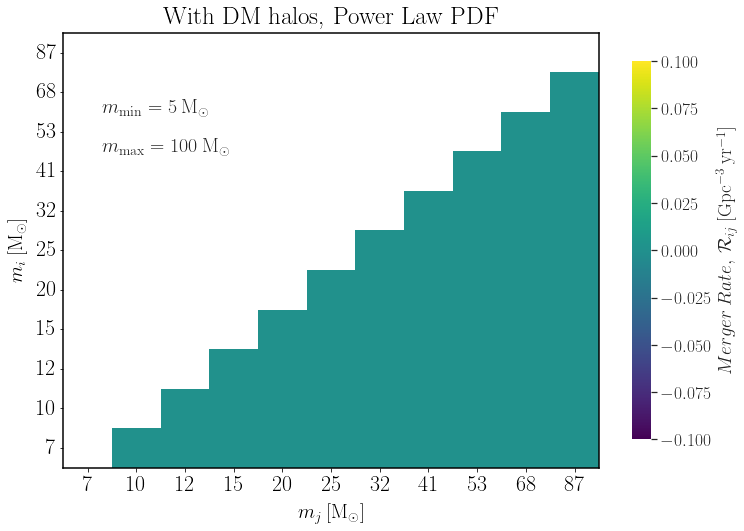

In [3]:
DM_halos_presence = 'True'
Merger_imripy_PWRhalo_1 = np.zeros((11, 11))



for i in range(11):
    for j in range(11):
        
        f_pbh = 1.18
        f = 0.85 * f_pbh
        
          
        def P(m): #Powerlaw PBH mass distribution
            α = 1.6
            M = 5     #in units of M☉, for PBHs mass range of m_min = 5 M☉ - m_min = 100 M☉ .
            return ((α-1)/M) * ((m/M)**(-α))

        if i==j:
            Merger_imripy_PWRhalo_1[i,j] = 0.5 * merger_IMRIPY(m_1_list[i], m_2_list[j], Δ_1_list[i], Δ_2_list[j], t_m, DM_halos_presence)
            
        else:
            Merger_imripy_PWRhalo_1[i,j] = merger_IMRIPY( m_1_list[i], m_2_list[j], Δ_1_list[i], Δ_2_list[j], t_m, DM_halos_presence)   
    
        


mask = np.tril(np.ones((11,11)), k = -1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax = plt.subplots(figsize=(12, 8))  




sns.set(font_scale = 1.6)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'



#  norm=LogNorm()


ax = sns.heatmap(Merger_imripy_PWRhalo_1, mask = mask,  cmap = 'viridis', cbar = True,   
                 cbar_kws = { "shrink": 0.87, 'label': '$Merger \: Rate, \: \mathcal{R}_{ij} \: [\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}]$'},
                  vmin = 0)




ax.set_xticklabels(m_1_list, fontsize = 10)
ax.set_yticklabels(m_2_list, rotation = 360, fontsize = 10)
ax.tick_params(left = True,  bottom = True)

ax.text(0.8, 9, "$m_\mathrm{{min}} = 5 \: \mathrm{M_{\odot}}$", size = 20)
ax.text(0.8, 8, "$m_\mathrm{{max}} = 100 \: \mathrm{M_{\odot}}$", size = 20)



# make frame visible
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    
    
ax.invert_yaxis()
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.xlabel('$m_{j}\:[\mathrm{M_{\odot}}]$', fontsize = 20, labelpad = 9)     # m_j = m_2
plt.ylabel('$m_{i}\: [\mathrm{M_{\odot}}]$', fontsize = 20, labelpad = 9)    # m_i = m_1  and m_2 < equal to m_1.
plt.title('With DM halos, Power Law PDF', fontsize = 25, pad = 9)
plt.show()     